In [1]:
import random as rd
import numpy as np
from collections import namedtuple,defaultdict
from copy import *
import matplotlib.pyplot as plt

### Parameters

In [2]:
# Ask for number of dedicated servers
while True:
    try:
        print('Nº of Dedicated Servers')
        n_servers = int(input())
        break
    except ValueError:
        pass

Nº of Dedicated Servers
25


Let
- $c_j\in\mathcal{U}(1,90),\;\forall j=0,1,\cdots,C$
- $r_j\in\mathcal{U}(5,40),\;\forall j=0,1,\cdots,C$
- $\lambda_j\in\mathcal{U}(1,r_j-1),\;\forall j=1,2,\cdots,C$

In [3]:
costs = [None]*(n_servers+1)
serv_rates = [None]*(n_servers+1)
arrival_rates = [None]*(n_servers+1)


# Set costs and rates randomly
rd.seed(n_servers)
for j in range(n_servers+1):
    c = round(rd.uniform(1,90))
    r = np.ceil(rd.uniform(5,40))
    costs[j] = c
    serv_rates[j] = r
    if j > 0:
        arrival_rates[j] = round(rd.uniform(1,r-1))

### Initial System

In [4]:
# Set initial system
Server = namedtuple('Server','cost,service_rate,arrival_rate,free_load_rate,relative_cost,delta')
System = defaultdict(Server)

# MSS
c = costs[0]
r = serv_rates[0]
System[0] = Server(c,r,None,None,round(c/r,2),1)

# Dedicated servers
for n in range(1,n_servers+1):
    cs = costs[n]
    rs = serv_rates[n]
    ls = arrival_rates[n]
    flr = round(ls/rs,2)
    rc = round(cs/rs,2)
    delta = round(np.sqrt(rc/(c/r)),2)
    System[n] = Server(cs,rs,ls,flr,rc,delta)

### Functions

In [5]:
def rho0(r0,Splus,S0):
    ''' INPUT
        r0   : MSS service rate
        Splus: set of servers that share part of their load
        S0   : set of servers that pass all of their load
        
        OUTPUT
        rho_0: MSS load rate (according to formulae in last chapter) '''
    
    sum1 = sum([server.service_rate-server.arrival_rate for server in Splus])
    sum2 = sum([server.arrival_rate for server in S0])
    sum3 = sum([server.service_rate*server.delta for server in Splus])
    rho_0 = 1-(r0+sum1-sum2)/(r0+sum3)
    return rho_0

In [6]:
def rhoj(server,r0,Splus,S0):
    ''' INPUT
        server: server  
        r0    : MSS load rate
        Splus : set of servers that share part of their load
        S0    : set of servers that pass all of their load
        
        OUTPUT
        rho_j : server load rate 
        '''
    if server in S0:
        return 0
    elif server in Splus:
        rho_0 = rho0(r0,Splus,S0)
        rho_j = 1-server.delta*(1-rho_0)
        return rho_j
    else:
        return server.free_load_rate

In [7]:
def ResultingSystem(initial_system):
    ''' INPUT
        initial_system: servers dictionary, including MSS; each server is a tuple with the following fields
                        - cost (c)
                        - service rate (r)
                        - arrival rate (lambda)
                        - initial load (lambda/r)
                        - relative cost (c/r)
                        - delta (sqrt[(c/r)/(c0/r0)])
        OUTPUT
        Sd   : set of servers that share nothing
        Splus: set of servers that share part of their load
        S0   : set of servers that pass all of their load
        '''
    
    n_servers = len(initial_system)
    MSS = initial_system[0]
    Splus = set(); S0 = set(); Sd = set()
    
    # If delta_j<=1-lambda_j/r_j ==> server j does not share, else server j will share
    for server in range(1,n_servers):
        if initial_system[server].delta <= 1-initial_system[server].free_load_rate:
            Sd.add(initial_system[server])
        else:
            Splus.add(initial_system[server])
            
    n_change = 10
    r0 = MSS.service_rate
    Sc = deepcopy(Splus)
    iteration = 0
    
    # Check conditions iteratively
    while n_change > 0:
        iteration += 1
        n_change = 0
        rho_0 = rho0(r0,Splus,S0)
        M = 1/(1-rho_0)  # upper bound for all servers
        for server in Sc:
            Mj = (1-server.free_load_rate)/(1-rho_0) # lower bound for server j
            # from Sd to S+
            if server in Sd and server.delta<M and server.delta>Mj:
                Splus.add(server)
                Sd.remove(server)
                n_change += 1
            # from Sd to S0
            elif server in Sd and server.delta>=M:
                S0.add(server)
                Sd.remove(server)
                n_change += 1
            # from S+ to S0
            elif server in Splus and server.delta>=M:
                S0.add(server)
                Splus.remove(server)
                n_change += 1
            # from S+ to Sd
            elif server in Splus and server.delta<=Mj:
                Sd.add(server)
                Splus.remove(server)
                n_change += 1
            # from S0 to S+
            elif server in S0 and server.delta<M and server.delta>Mj:
                Splus.add(server)
                S0.remove(server)
                n_change += 1
            # from S0 to Sd
            elif server in S0 and server.delta<=Mj:
                Sd.add(server)
                S0.remove(server)
                n_change += 1
    return Sd,Splus,S0,iteration

### Run and results

In [8]:
Sd,Splus,S0,it = ResultingSystem(System)
print('Number of iterations required: %i' % it)

Number of iterations required: 3


In [9]:
Sd # servers staying independent

{Server(cost=14, service_rate=39.0, arrival_rate=15.0, free_load_rate=0.38, relative_cost=0.36, delta=0.63),
 Server(cost=15, service_rate=22.0, arrival_rate=2.0, free_load_rate=0.09, relative_cost=0.68, delta=0.86),
 Server(cost=16, service_rate=26.0, arrival_rate=16.0, free_load_rate=0.62, relative_cost=0.62, delta=0.82),
 Server(cost=24, service_rate=16.0, arrival_rate=7.0, free_load_rate=0.44, relative_cost=1.5, delta=1.28),
 Server(cost=33, service_rate=22.0, arrival_rate=3.0, free_load_rate=0.14, relative_cost=1.5, delta=1.28),
 Server(cost=37, service_rate=34.0, arrival_rate=21.0, free_load_rate=0.62, relative_cost=1.09, delta=1.09),
 Server(cost=42, service_rate=22.0, arrival_rate=5.0, free_load_rate=0.23, relative_cost=1.91, delta=1.44),
 Server(cost=46, service_rate=22.0, arrival_rate=2.0, free_load_rate=0.09, relative_cost=2.09, delta=1.51),
 Server(cost=49, service_rate=21.0, arrival_rate=7.0, free_load_rate=0.33, relative_cost=2.33, delta=1.59),
 Server(cost=51, service_ra

In [10]:
Splus # servers sharing part of their load

{Server(cost=13, service_rate=9.0, arrival_rate=6.0, free_load_rate=0.67, relative_cost=1.44, delta=1.25),
 Server(cost=45, service_rate=22.0, arrival_rate=15.0, free_load_rate=0.68, relative_cost=2.05, delta=1.49),
 Server(cost=53, service_rate=10.0, arrival_rate=6.0, free_load_rate=0.6, relative_cost=5.3, delta=2.4),
 Server(cost=58, service_rate=7.0, arrival_rate=6.0, free_load_rate=0.86, relative_cost=8.29, delta=3.0),
 Server(cost=74, service_rate=13.0, arrival_rate=6.0, free_load_rate=0.46, relative_cost=5.69, delta=2.49),
 Server(cost=75, service_rate=23.0, arrival_rate=18.0, free_load_rate=0.78, relative_cost=3.26, delta=1.88),
 Server(cost=76, service_rate=13.0, arrival_rate=11.0, free_load_rate=0.85, relative_cost=5.85, delta=2.52),
 Server(cost=79, service_rate=7.0, arrival_rate=2.0, free_load_rate=0.29, relative_cost=11.29, delta=3.5)}

In [11]:
S0 # servers passing all of their load

set()

In [12]:
r0 = System[0].service_rate
rho_0 = rho0(r0,Splus,S0)
print(' MSS Load: %4.3f' % rho_0)
print()
for s in System:
    if s>0:
        server = System[s]
        rho_j = rhoj(server,r0,Splus,S0)
        print(' Server[%2i]   Initial Load: %4.3f --> Resulting Load: %4.3f' % (s,server.free_load_rate,rho_j))

 MSS Load: 0.723

 Server[ 1]   Initial Load: 0.850 --> Resulting Load: 0.302
 Server[ 2]   Initial Load: 0.860 --> Resulting Load: 0.169
 Server[ 3]   Initial Load: 0.440 --> Resulting Load: 0.440
 Server[ 4]   Initial Load: 0.600 --> Resulting Load: 0.335
 Server[ 5]   Initial Load: 0.780 --> Resulting Load: 0.479
 Server[ 6]   Initial Load: 0.210 --> Resulting Load: 0.210
 Server[ 7]   Initial Load: 0.140 --> Resulting Load: 0.140
 Server[ 8]   Initial Load: 0.140 --> Resulting Load: 0.140
 Server[ 9]   Initial Load: 0.200 --> Resulting Load: 0.200
 Server[10]   Initial Load: 0.090 --> Resulting Load: 0.090
 Server[11]   Initial Load: 0.170 --> Resulting Load: 0.170
 Server[12]   Initial Load: 0.290 --> Resulting Load: 0.030
 Server[13]   Initial Load: 0.460 --> Resulting Load: 0.310
 Server[14]   Initial Load: 0.480 --> Resulting Load: 0.480
 Server[15]   Initial Load: 0.090 --> Resulting Load: 0.090
 Server[16]   Initial Load: 0.130 --> Resulting Load: 0.130
 Server[17]   Initial 

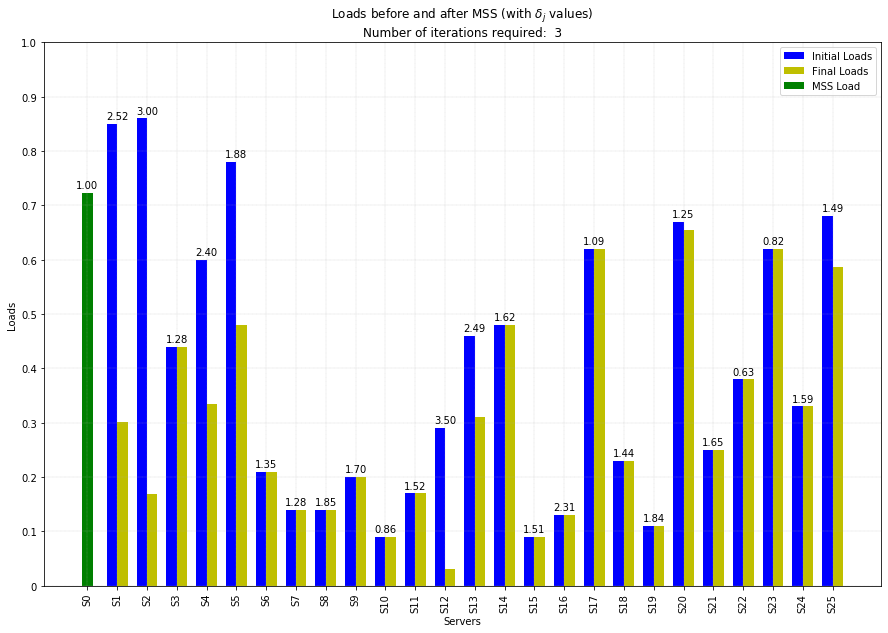

In [13]:
#def PlotLoadChart():
    
N = n_servers + 1
initial_loads = [server.free_load_rate*10 for server in System.values() if server.free_load_rate]

ind   = np.arange(N)
width = 0.35

fig, ax = plt.subplots(figsize=(15,10))
ax.grid(linestyle='--',linewidth=0.25)
rects1 = ax.bar(ind[1:,], initial_loads, width, color='b')

final_loads = [rhoj(server,r0,Splus,S0)*10 for server in System.values() if server.free_load_rate]
rectMSS = ax.bar(width/2, rho_0*10, width, color = 'g')
rects2 = ax.bar(ind[1:,]+width,final_loads,width,color='y') 

ax.set_xlabel('Servers')
ax.set_ylabel('Loads')
ax.set_title(r'Loads before and after MSS (with $\delta_j$ values)' + '\nNumber of iterations required: %2i' % it)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(['S'+str(i) for i in ind],rotation='vertical',va='top')
ax.set_yticks((0,1,2,3,4,5,6,7,8,9,10))
ax.set_yticklabels(['0','0.1','0.2','0.3','0.4','0.5','0.6','0.7','0.8','0.9','1.0'])

for ix in list(System.keys()):
    x = ind[ix]
    server = System[ix]
    if ix == 0:
        y = rho_0*10
    else:
        y = max([server.free_load_rate,rhoj(server,r0,Splus,S0)])*10
    ax.text(x+width/2,.05+y,'%4.2f' % server.delta,ha='center',va='bottom')

ax.legend((rects1,rects2,rectMSS),('Initial Loads','Final Loads','MSS Load'))
plt.show()